**How many flights have scheduled ground time close to or below the minimum turn mins?**

In [1]:
import duckdb
con = duckdb.connect('../sql_databases/skyhack.duckdb')
con.execute("SHOW TABLES").df()

,name
0,PNRFlight
1,airports_cleaned
2,bagsData_cleaned
3,flight_difficulty_ml
4,flight_difficulty_ml_enriched
5,flights_cleaned
6,pnr_remarks_cleaned


In [2]:
sql = '''WITH ground_calc AS (
  SELECT
    scheduled_ground_time_minutes,
    minimum_turn_minutes,
    (scheduled_ground_time_minutes - minimum_turn_minutes) AS buffer_time
  FROM flights_cleaned
  WHERE scheduled_ground_time_minutes IS NOT NULL
    AND minimum_turn_minutes IS NOT NULL
)
SELECT
  COUNT(*) AS total_flights,
  SUM(CASE WHEN buffer_time <= 0 THEN 1 ELSE 0 END) AS flights_below_or_equal,
  100.0 * SUM(CASE WHEN buffer_time <= 0 THEN 1 ELSE 0 END) / COUNT(*) AS percentage_below_or_equal,
  SUM(CASE WHEN buffer_time > 0 AND buffer_time <= 10 THEN 1 ELSE 0 END) AS flights_close_to_min_turn,
  100.0 * SUM(CASE WHEN buffer_time > 0 AND buffer_time <= 10 THEN 1 ELSE 0 END) / COUNT(*) AS percentage_close_to_min_turn
FROM ground_calc ''' 

con.execute(sql).df()  #taking threshold as 10 minuter, within this it is considered close to minimum

,total_flights,flights_below_or_equal,percentage_below_or_equal,flights_close_to_min_turn,percentage_close_to_min_turn
0,8065,630.0,7.811531,530.0,6.571606


In [3]:
sql_query = '''WITH buffer AS (
  SELECT
    scheduled_ground_time_minutes - minimum_turn_minutes AS buffer_time
  FROM flights_cleaned
  WHERE scheduled_ground_time_minutes IS NOT NULL
    AND minimum_turn_minutes IS NOT NULL
)
SELECT
  CASE
    WHEN buffer_time < 0 THEN '< 0'
    WHEN buffer_time BETWEEN 0 AND 5 THEN '0–5'
    WHEN buffer_time BETWEEN 6 AND 10 THEN '6–10'
    WHEN buffer_time BETWEEN 11 AND 15 THEN '11–15'
    WHEN buffer_time BETWEEN 16 AND 30 THEN '16–30'
    WHEN buffer_time BETWEEN 31 AND 60 THEN '31–60'
    ELSE '60+'
  END AS buffer_bin,
  COUNT(*) AS flight_count
FROM buffer
GROUP BY 1
ORDER BY MIN(buffer_time)''' 

df_hist = con.execute(sql_query).df()

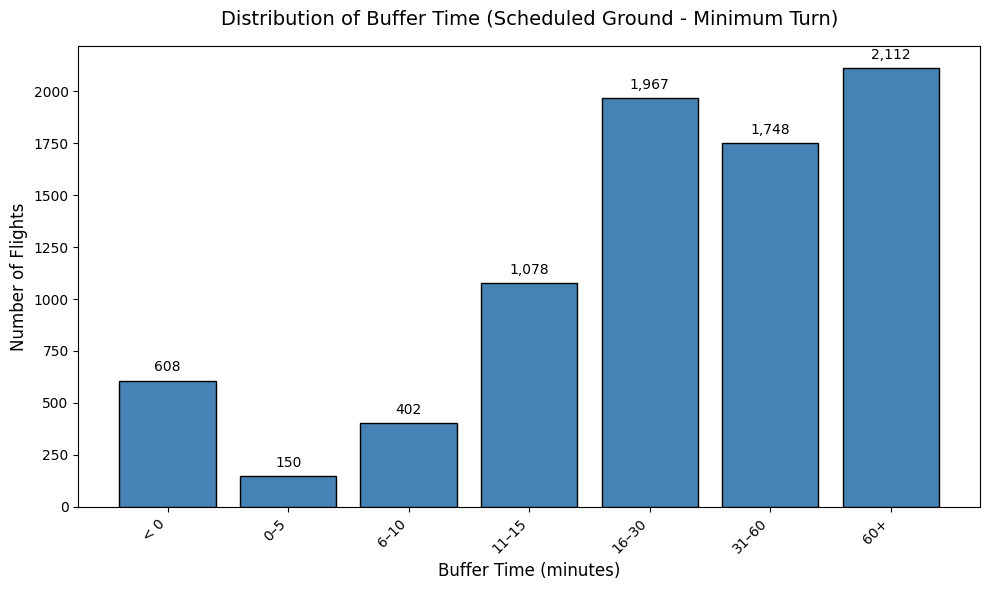

In [4]:
import matplotlib.pyplot as plt

# Extract bins and counts
bins = df_hist['buffer_bin']
counts = df_hist['flight_count']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(bins, counts, color='steelblue', edgecolor='black')

# Labels & title
plt.title('Distribution of Buffer Time (Scheduled Ground - Minimum Turn)', fontsize=14, pad=15)
plt.xlabel('Buffer Time (minutes)', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)

# Rotate x-axis labels 
plt.xticks(rotation=45, ha='right')

# Add data labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 30, f'{yval:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
sql_query_1 = '''SELECT
  approx_quantile(
    scheduled_ground_time_minutes - minimum_turn_minutes,
    0.10
  ) AS p10_buffer_time,
  approx_quantile(
    scheduled_ground_time_minutes - minimum_turn_minutes,
    0.25
  ) AS p25_buffer_time,
  approx_quantile(
    scheduled_ground_time_minutes - minimum_turn_minutes,
    0.50
  ) AS median_buffer_time
FROM flights_cleaned
WHERE scheduled_ground_time_minutes IS NOT NULL
  AND minimum_turn_minutes IS NOT NULL ''' 

df_quant = con.execute(sql_query_1).df()

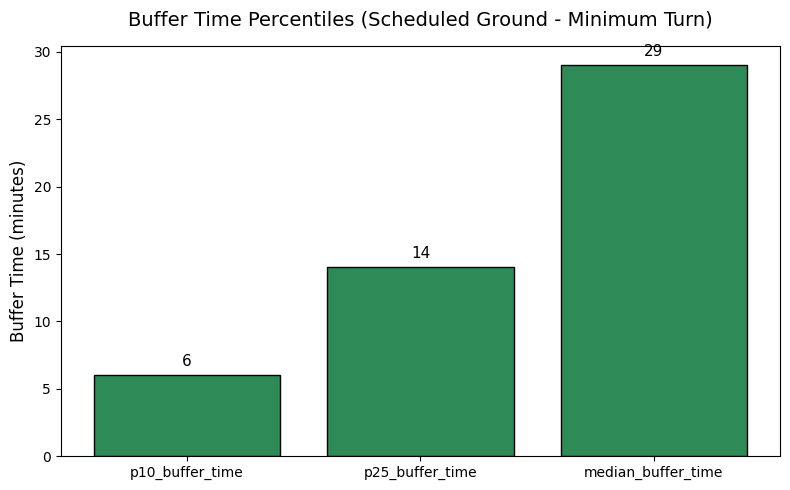

In [6]:

# Extract the percentile values from the single row
values = df_quant.iloc[0].values
labels = df_quant.columns.tolist()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color='seagreen', edgecolor='black')

# Title and labels
plt.title('Buffer Time Percentiles (Scheduled Ground - Minimum Turn)', fontsize=14, pad=15)
plt.ylabel('Buffer Time (minutes)', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.0f}', 
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


In [7]:
con.close()